In [1]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pdb
import seaborn as sns
import warnings
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader, TensorDataset,  random_split
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
# Load dataset
data = pd.read_csv('D:\\Excel data\\Saliva\\Healthy (Control)\\CONTROL DATASET.csv')

# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

In [3]:
# PCA
pca = PCA(n_components=0.999)  
data_pca = pca.fit_transform(data_scaled)

In [4]:
# Convert the normalized data to a PyTorch tensor
data_tensor = torch.tensor(data_pca, dtype=torch.float32)

# Data dimensions (number of features)
input_dim = data_tensor.shape[1]

In [5]:
data.describe()

,Wavelenght399,Wavelenght400,Wavelenght401,Wavelenght402,Wavelenght403,Wavelenght404,Wavelenght405,Wavelenght406,Wavelenght407,Wavelenght408,...,Wavelenght4125,Wavelenght4126,Wavelenght4127,Wavelenght4128,Wavelenght4129,Wavelenght4130,Wavelenght4131,Wavelenght4132,Wavelenght4133,Wavelenght4134
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,...,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,0.012250,0.012573,0.012779,0.012926,0.013061,0.013238,0.013531,0.014002,0.014646,0.015350,...,0.040388,0.040300,0.040234,0.040180,0.040106,0.039998,0.039881,0.039802,0.039797,0.040209
std,0.015259,0.012853,0.011097,0.010596,0.010968,0.011433,0.011563,0.011362,0.011077,0.010877,...,0.018788,0.018811,0.018828,0.018838,0.018845,0.018849,0.018849,0.018842,0.018833,0.018927
min,-0.014772,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,...,0.006680,0.006636,0.006627,0.006655,0.006709,0.006764,0.006788,0.006755,0.006663,0.006622
25%,0.001975,0.001600,0.003526,0.004287,0.004016,0.003564,0.003591,0.004327,0.005191,0.006842,...,0.025167,0.025067,0.025030,0.025106,0.025090,0.024775,0.024625,0.024532,0.024590,0.024983
50%,0.007490,0.007041,0.009273,0.009949,0.009853,0.009641,0.010528,0.011109,0.011913,0.012970,...,0.038208,0.038166,0.037753,0.037555,0.037466,0.037299,0.037059,0.037192,0.037245,0.037873
75%,0.021905,0.021530,0.019229,0.020147,0.020276,0.020476,0.019827,0.020090,0.021587,0.022612,...,0.054194,0.054263,0.054213,0.054108,0.054246,0.054207,0.054018,0.054151,0.054101,0.054605
max,0.061457,0.057453,0.053860,0.048561,0.044788,0.047300,0.049513,0.049830,0.047316,0.047338,...,0.094441,0.094415,0.094062,0.093442,0.092693,0.092002,0.091551,0.091427,0.091561,0.092710


In [6]:
# Wrap the tensor in a TensorDataset 
dataset = TensorDataset(data_tensor)

# Create a DataLoader
batch_size = 64
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Example: iterate over batches
for batch in data_loader:
    inputs = batch[0]  
    print(inputs.shape)

torch.Size([64, 62])
torch.Size([64, 62])
torch.Size([64, 62])
torch.Size([64, 62])
torch.Size([64, 62])
torch.Size([64, 62])
torch.Size([64, 62])
torch.Size([52, 62])


In [7]:
# Wrap data tensor in a TensorDataset
dataset = TensorDataset(data_tensor)

# Define split ratio 
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

# Split dataset
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders for each split
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Example: Access batches
for batch in train_loader:
    inputs = batch[0]
    print(f"Train batch shape: {inputs.shape}")
    break

for batch in test_loader:
    inputs = batch[0]
    print(f"Test batch shape: {inputs.shape}")
    break

Train batch shape: torch.Size([64, 62])
Test batch shape: torch.Size([64, 62])


In [8]:
# Xavier initialization
def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

In [9]:
noise_dim = 100
input_dim = 3736
epochs = 10000
batch_size = 64


# Generator network (improved)
class Generator(nn.Module):
    def __init__(self, noise_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, output_dim),
        )

    def forward(self, x):
        return self.model(x)

# Discriminator network (improved)
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [10]:
input_dim = data_tensor.shape[1]  
noise_dim = 100  

generator = Generator(noise_dim=noise_dim, output_dim=input_dim)
discriminator = Discriminator(input_dim=input_dim)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator.to(device)
discriminator.to(device)

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=62, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=128, out_features=1, bias=True)
    (7): Sigmoid()
  )
)

In [11]:
# Initialize models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = Generator(noise_dim=noise_dim, output_dim=input_dim).to(device)
discriminator = Discriminator(input_dim=input_dim).to(device)

In [12]:
# Hyperparameters
noise_dim = 100
input_dim = 3736
epochs = 10000
batch_size = 64
lr_D = 0.0001
lr_G = 0.0002
beta1 = 0.5

adversarial_loss = nn.BCELoss()
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))

scheduler_G = torch.optim.lr_scheduler.StepLR(optimizer_G, step_size=300, gamma=0.95)
scheduler_D = torch.optim.lr_scheduler.StepLR(optimizer_D, step_size=300, gamma=0.95)

In [13]:
# Apply weight initialization
generator.apply(weights_init)
discriminator.apply(weights_init)

print("Models initialized & moved to:", device)

Models initialized & moved to: cpu


In [14]:
# Function to generate random noise for the generator
def generate_latent_points(batch_size, noise_dim, device):
    return torch.randn(batch_size, noise_dim, device=device)

Epoch [1000/10000] | D Loss: 0.6791 | G Loss: 0.6880
Generated images shape: (16, 62)
Epoch [2000/10000] | D Loss: 0.6930 | G Loss: 0.7221
Generated images shape: (16, 62)
Epoch [3000/10000] | D Loss: 0.6827 | G Loss: 0.7314
Generated images shape: (16, 62)
Epoch [4000/10000] | D Loss: 0.6587 | G Loss: 0.7794
Generated images shape: (16, 62)
Epoch [5000/10000] | D Loss: 0.6446 | G Loss: 0.7270
Generated images shape: (16, 62)
Epoch [6000/10000] | D Loss: 0.5899 | G Loss: 0.7886
Generated images shape: (16, 62)
Epoch [7000/10000] | D Loss: 0.6168 | G Loss: 0.7761
Generated images shape: (16, 62)
Epoch [8000/10000] | D Loss: 0.6420 | G Loss: 0.7693
Generated images shape: (16, 62)
Epoch [9000/10000] | D Loss: 0.6492 | G Loss: 0.8719
Generated images shape: (16, 62)
Epoch [10000/10000] | D Loss: 0.6713 | G Loss: 0.7670
Generated images shape: (16, 62)


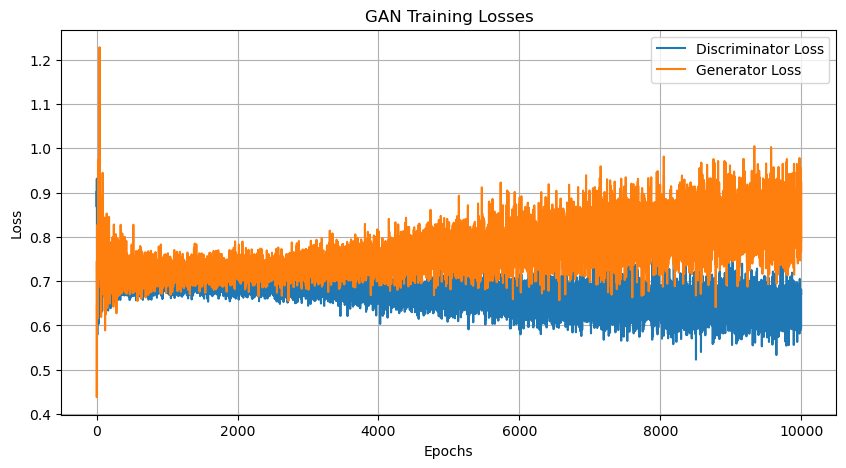

In [15]:
# Loss tracking
d_losses = []
g_losses = []

for epoch in range(epochs):
    generator.train()
    discriminator.train()

    for batch in train_loader:
        real_data = batch[0].to(device)
        batch_size_real = real_data.size(0)

        # Add Gaussian noise to real data
        noisy_real_data = real_data + 0.1 * torch.randn_like(real_data)

        # Labels with smoothing and noise
        real_labels = 0.9 + 0.1 * torch.rand((batch_size_real, 1), device=device)
        fake_labels = 0.05 * torch.rand((batch_size_real, 1), device=device)

        # --- Train Discriminator ---
        optimizer_D.zero_grad()

        z = generate_latent_points(batch_size_real, noise_dim, device)
        fake_data = generator(z)

        d_real = discriminator(noisy_real_data)
        d_fake = discriminator(fake_data.detach())

        d_loss_real = adversarial_loss(d_real, real_labels)
        d_loss_fake = adversarial_loss(d_fake, fake_labels)
        d_loss = (d_loss_real + d_loss_fake) / 2
        d_loss.backward()
        optimizer_D.step()

        # --- Train Generator ---
        for _ in range(3):
            optimizer_G.zero_grad()
            z = generate_latent_points(batch_size_real, noise_dim, device)
            fake_data = generator(z)
            d_fake = discriminator(fake_data)
            g_loss = adversarial_loss(d_fake, real_labels)
            g_loss.backward()
            optimizer_G.step()

    scheduler_G.step()
    scheduler_D.step()

    d_losses.append(d_loss.item())
    g_losses.append(g_loss.item())

    if (epoch + 1) % 1000 == 0:
        print(f"Epoch [{epoch+1}/{epochs}] | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")
        with torch.no_grad():
            test_fake = generator(generate_latent_points(16, noise_dim, device)).cpu().numpy()
            print("Generated images shape:", test_fake.shape)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(d_losses, label='Discriminator Loss')
plt.plot(g_losses, label='Generator Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.title("GAN Training Losses")
plt.show()

In [16]:
# Generate synthetic data

def generate_synthetic_data(generator, noise_dim, num_samples, device, pca=None, scaler=None):

    # Set generator to evaluation mode
    generator.eval()

    # Generate random noise (latent points)
    z = generate_latent_points(num_samples, noise_dim, device)

    # Generate synthetic data in PCA space
    with torch.no_grad():
        synthetic_pca_data = generator(z).cpu().numpy()

    # Inverse PCA transform (back to scaled feature space)
    if pca:
        synthetic_scaled = pca.inverse_transform(synthetic_pca_data)
    else:
        synthetic_scaled = synthetic_pca_data  

    # Inverse scaling (back to original feature space)
    if scaler:
        synthetic_final = scaler.inverse_transform(synthetic_scaled)
    else:
        synthetic_final = synthetic_scaled

    return synthetic_final


# === Example Usage ===

# Number of synthetic samples to generate
num_samples = 500

# Generate synthetic data
synthetic_data = generate_synthetic_data(
    generator=generator,
    noise_dim=noise_dim,
    num_samples=num_samples,
    device=device,
    pca=pca,       
    scaler=scaler  
)

# Convert to DataFrame
synthetic_df = pd.DataFrame(synthetic_data, columns=data.columns if 'data' in globals() else None)

# Display result
print(synthetic_df.head())

   Wavelenght399  Wavelenght400  Wavelenght401  Wavelenght402  Wavelenght403  \
0      -0.013574      -0.004102       0.007636       0.017009       0.022178   
1       0.045897       0.044109       0.036425       0.026352       0.016364   
2      -0.005924       0.009886       0.023372       0.031644       0.034451   
3      -0.018791      -0.009883       0.001738       0.013279       0.023349   
4       0.028916       0.024526       0.022429       0.021784       0.021964   

   Wavelenght404  Wavelenght405  Wavelenght406  Wavelenght407  Wavelenght408  \
0       0.023445       0.022559       0.021871       0.023262       0.027276   
1       0.008074       0.002641       0.000719       0.002048       0.005256   
2       0.033194       0.030041       0.027097       0.025559       0.025301   
3       0.031285       0.036771       0.039754       0.040446       0.039260   
4       0.022982       0.024933       0.027443       0.029527       0.029794   

   ...  Wavelenght4125  Wavelenght4126

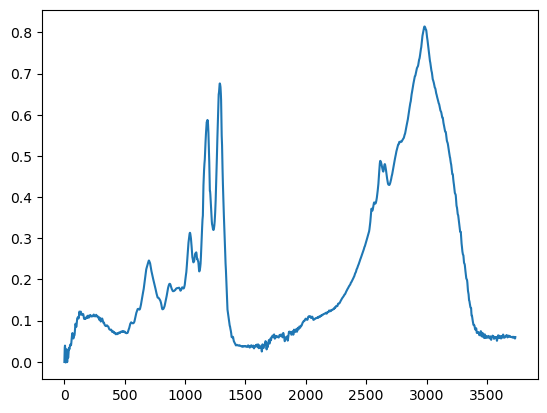

In [17]:
plt.plot(synthetic_data [10,:])

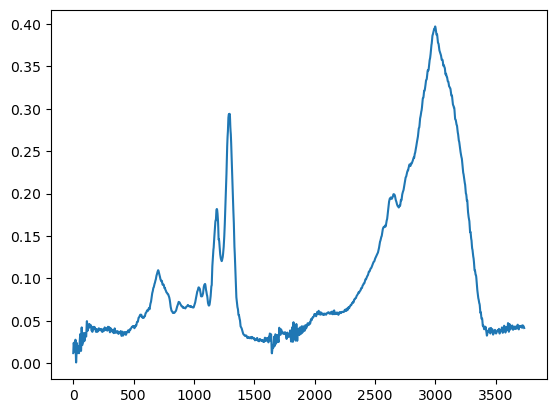

In [18]:
data = np.array(data) 
plt.plot(data[10, :]) 

In [19]:
# Save to CSV
synthetic_df.to_csv('synthetic_data_GB.csv', index=False)

In [20]:
synthetic_data = pd.read_csv('C:\\Users\\Ahmed\\Final\\synthetic_data_GB.csv') 

In [21]:
synthetic_data.describe()

,Wavelenght399,Wavelenght400,Wavelenght401,Wavelenght402,Wavelenght403,Wavelenght404,Wavelenght405,Wavelenght406,Wavelenght407,Wavelenght408,...,Wavelenght4125,Wavelenght4126,Wavelenght4127,Wavelenght4128,Wavelenght4129,Wavelenght4130,Wavelenght4131,Wavelenght4132,Wavelenght4133,Wavelenght4134
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,...,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,0.010909,0.011549,0.012182,0.012804,0.013414,0.013991,0.014505,0.014937,0.015294,0.015565,...,0.039832,0.039760,0.039742,0.039744,0.039710,0.039614,0.039480,0.039369,0.039335,0.039724
std,0.015584,0.012673,0.010486,0.009938,0.010594,0.011370,0.011722,0.011658,0.011478,0.011430,...,0.017513,0.017546,0.017554,0.017560,0.017578,0.017597,0.017601,0.017578,0.017543,0.017580
min,-0.089268,-0.048395,-0.033218,-0.019322,-0.009798,-0.008731,-0.010935,-0.010265,-0.013064,-0.015846,...,0.004683,0.004660,0.004566,0.003515,0.002373,0.001426,0.000923,0.001012,0.001669,0.003070
25%,0.002321,0.003444,0.004746,0.005699,0.006040,0.006626,0.007146,0.007297,0.007449,0.008208,...,0.024967,0.025033,0.024855,0.024933,0.024875,0.024539,0.024572,0.024551,0.024620,0.025280
50%,0.010246,0.010937,0.011218,0.011892,0.012711,0.012582,0.012414,0.013030,0.013490,0.014028,...,0.039530,0.039410,0.039636,0.039145,0.038838,0.038634,0.038444,0.038436,0.038609,0.038882
75%,0.018184,0.018765,0.017928,0.018635,0.018447,0.018882,0.019242,0.020131,0.020785,0.021593,...,0.053289,0.053102,0.053164,0.053162,0.053016,0.052418,0.052608,0.052699,0.052709,0.052892
max,0.069734,0.062063,0.049283,0.048542,0.063188,0.077049,0.081747,0.082523,0.084071,0.087469,...,0.086890,0.086937,0.087384,0.087580,0.087642,0.087581,0.087247,0.086754,0.086284,0.087263


In [22]:
Y = pd.read_csv("synthetic_data_GB.csv")  

In [23]:
print (Y)

     Wavelenght399  Wavelenght400  Wavelenght401  Wavelenght402  \
0        -0.013574      -0.004102       0.007636       0.017009   
1         0.045897       0.044109       0.036425       0.026352   
2        -0.005924       0.009886       0.023372       0.031644   
3        -0.018791      -0.009883       0.001738       0.013279   
4         0.028916       0.024526       0.022429       0.021784   
..             ...            ...            ...            ...   
495       0.010559       0.013433       0.012925       0.011403   
496       0.035553       0.031167       0.025954       0.021276   
497       0.055898       0.045218       0.032335       0.018360   
498       0.029235       0.023989       0.018410       0.014980   
499       0.016742       0.012179       0.008181       0.004793   

     Wavelenght403  Wavelenght404  Wavelenght405  Wavelenght406  \
0         0.022178       0.023445       0.022559       0.021871   
1         0.016364       0.008074       0.002641       0.0007

In [24]:
data_fake = Y

In [25]:
pip install --upgrade table_evaluator

Note: you may need to restart the kernel to use updated packages.


In [26]:
from table_evaluator import load_data, TableEvaluator

In [27]:
real, fake = load_data('D:\\Excel data\\Saliva\\Healthy (Control)\\CONTROL DATASET.csv', 'C:\\Users\\Ahmed\\Final\\synthetic_data_GB.csv')

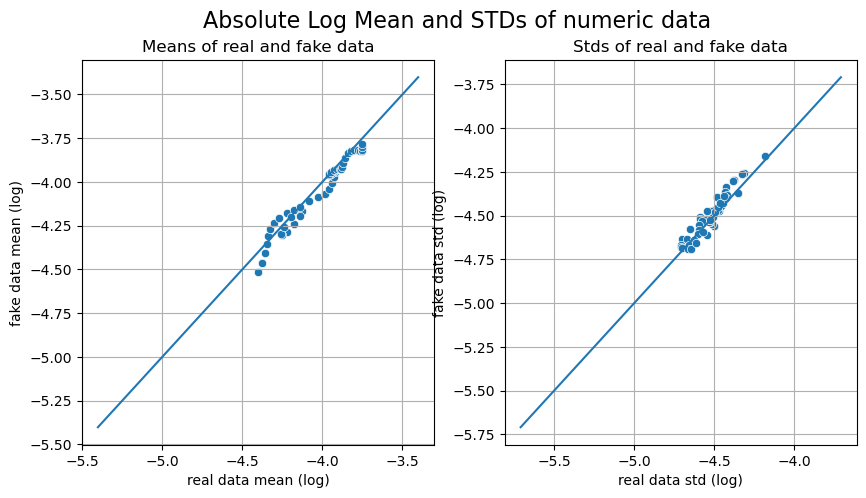

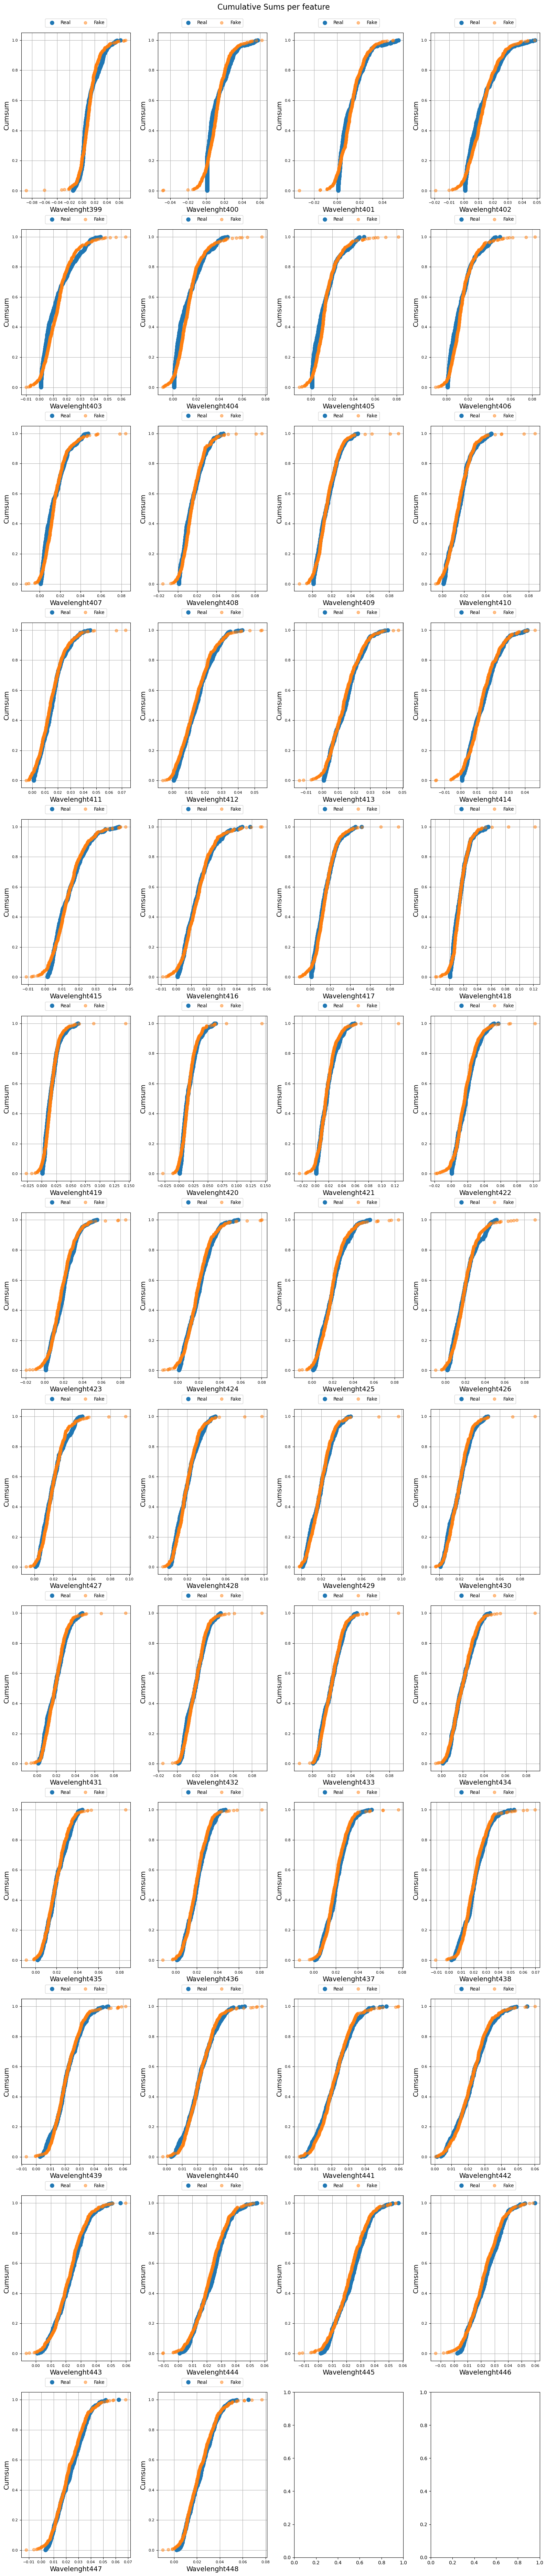

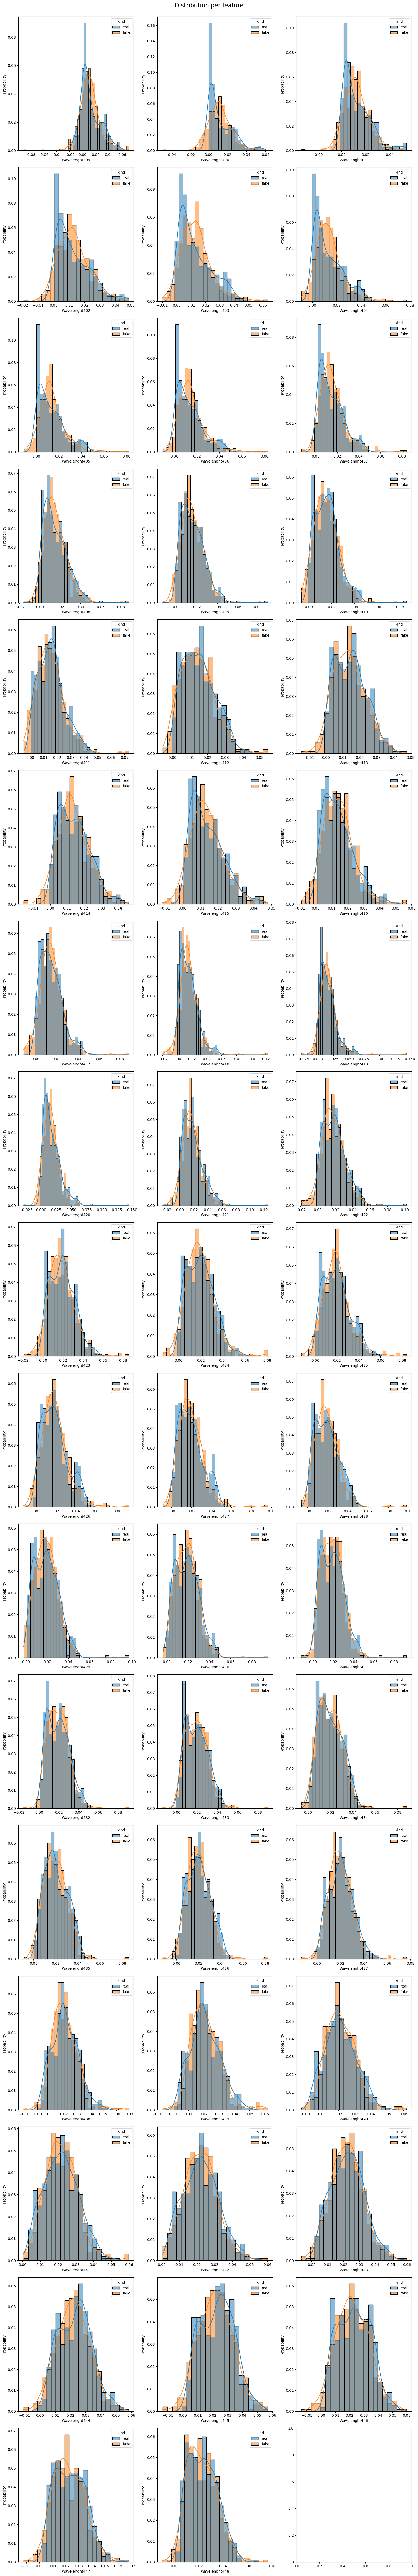

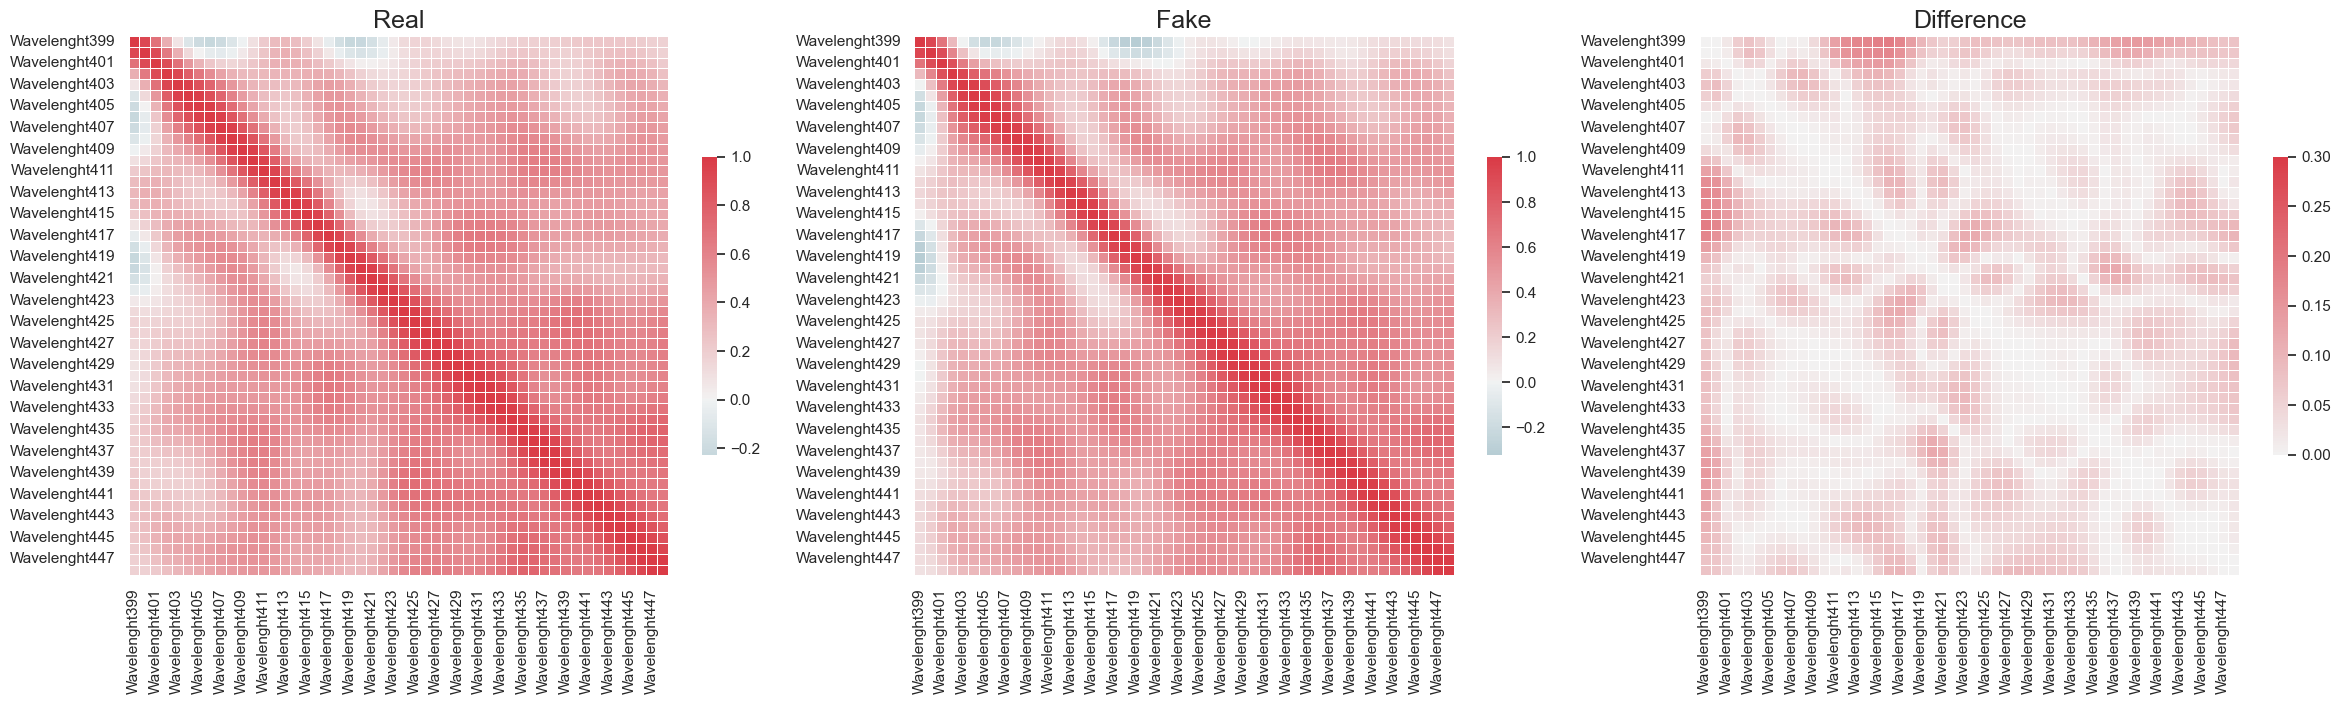

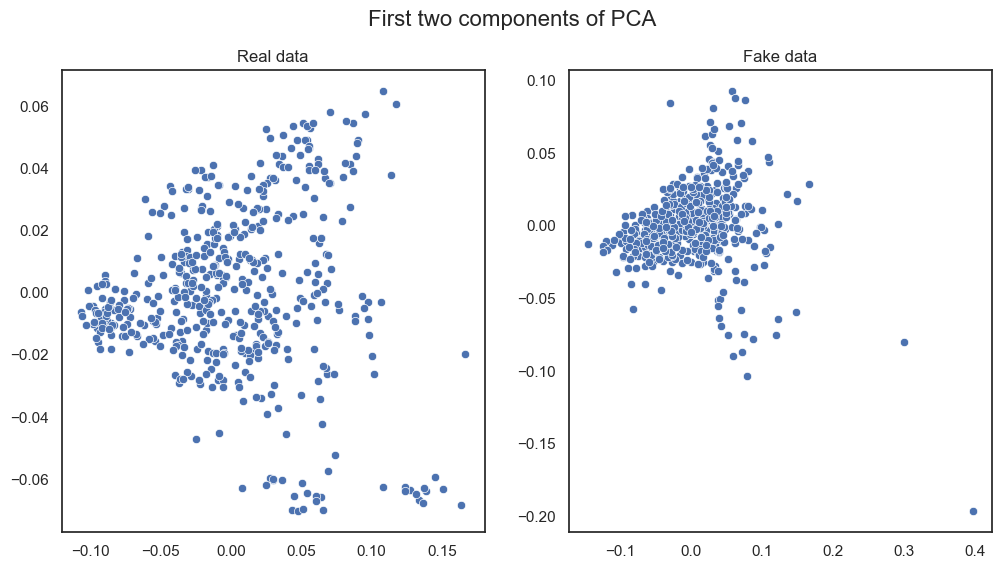

In [28]:
# Load your data into pandas DataFrames
real_data = pd.read_csv('D:\\Excel data\\Saliva\\Healthy (Control)\\CONTROL DATASET.csv')
fake_data = pd.read_csv('C:\\Users\\Ahmed\\Final\\synthetic_data_GB.csv')

# Now you can proceed with your code
real = real_data
fake = fake_data

selected_columns = real_data.columns[:50]  
real_subset = real_data[selected_columns]
fake_subset = fake_data[selected_columns]

table_evaluator = TableEvaluator(real_subset, fake_subset)
table_evaluator.visual_evaluation()


In [29]:
# Apply the Classifier

# Suppress warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# === Label datasets ===
real['label'] = 0  # Real
fake['label'] = 1  # Synthetic

# === Combine datasets ===
combined_data = pd.concat([real, fake], ignore_index=True)

# === Shuffle the data ===
combined_data = combined_data.sample(frac=1, random_state=42).reset_index(drop=True)

# === Split features and labels ===
X = combined_data.drop('label', axis=1)
y = combined_data['label']

# === Train/test split ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [30]:
GradientBoostingClassifier(n_estimators=100, learning_rate=0.001, max_depth=3, random_state=42)

# === Train Gradient Boosting Classifier ===
clf = GradientBoostingClassifier(random_state=42)
clf.fit(X_train, y_train)

# === Predict ===
y_pred = clf.predict(X_test)

# === Evaluation ===
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

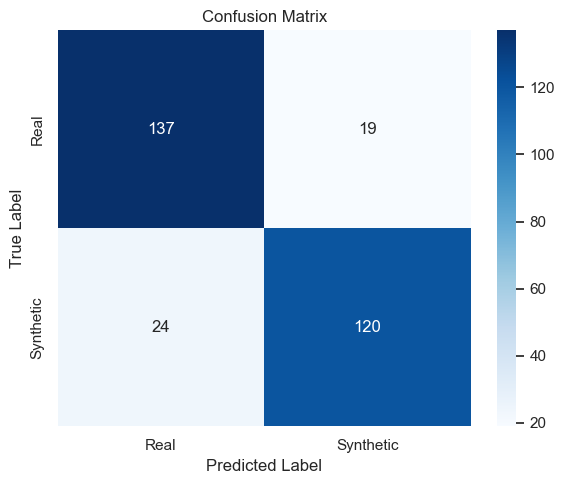

Accuracy:  0.86
Precision: 0.86
Recall:    0.83
F1 Score:  0.85


In [31]:
# === Display Confusion Matrix ===
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Real", "Synthetic"],
            yticklabels=["Real", "Synthetic"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix")
plt.tight_layout()
plt.show()

# === Print Metrics ===
print(f"Accuracy:  {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall:    {recall:.2f}")
print(f"F1 Score:  {f1:.2f}")

In [32]:
# 10-folds cross validation 

# === Label datasets ===
real['label'] = 0  # Real
fake['label'] = 1  # Synthetic

# === Combine datasets ===
combined_data = pd.concat([real, fake], ignore_index=True)
combined_data = combined_data.sample(frac=1, random_state=42).reset_index(drop=True)

# === Split features and labels ===
X = combined_data.drop('label', axis=1)
y = combined_data['label']

# === Set up Gradient Boosting Classifier and Cross-Validation ===
clf = GradientBoostingClassifier(random_state=42)
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# === Cross-validated predictions ===
y_pred = cross_val_predict(clf, X, y, cv=cv)

Accuracy:  0.8720
Precision: 0.8750
Recall:    0.8680
F1 Score:  0.8715


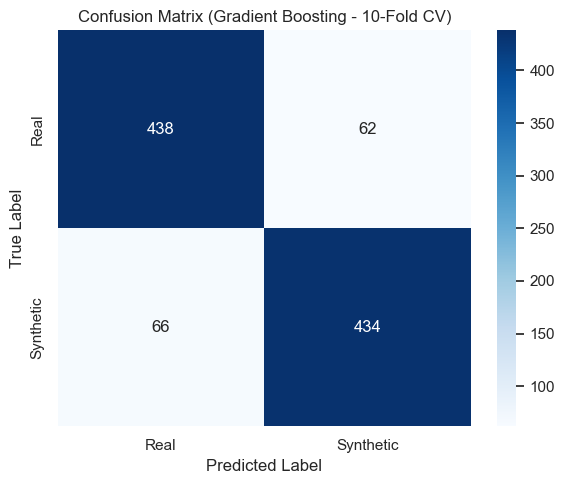

In [33]:
# === Compute metrics ===
accuracy = accuracy_score(y, y_pred)
precision = precision_score(y, y_pred)
recall = recall_score(y, y_pred)
f1 = f1_score(y, y_pred)
conf_matrix = confusion_matrix(y, y_pred)

# === Print metrics ===
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

# === Plot Confusion Matrix ===
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Real", "Synthetic"],
            yticklabels=["Real", "Synthetic"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Gradient Boosting - 10-Fold CV)')
plt.tight_layout()
plt.show()

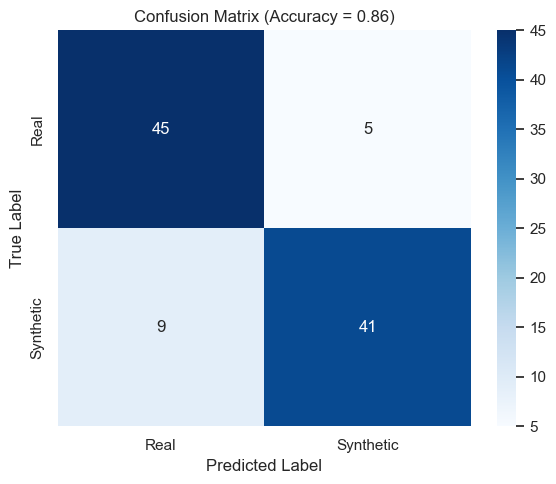

Accuracy:  0.8600
Precision: 0.8913
Recall:    0.8200
F1 Score:  0.8542


In [34]:
# Mixed the Real and the fake data, took 50% of each dataset, and combined them. 

# === Load datasets ===
real_data = pd.read_csv('D:\\Excel data\\Saliva\\Healthy (Control)\\CONTROL DATASET.csv')
fake_data = pd.read_csv('C:\\Users\\Ahmed\\Final\\synthetic_data_GB.csv')

# === Take 50% from each dataset ===
real_sample = real_data.sample(frac=0.5, random_state=42)
fake_sample = fake_data.sample(frac=0.5, random_state=42)

# === Label the datasets ===
real_sample['label'] = 0  # Real
fake_sample['label'] = 1  # Synthetic

# === Combine datasets ===
combined_data = pd.concat([real_sample, fake_sample], ignore_index=True)
combined_data = combined_data.sample(frac=1, random_state=42).reset_index(drop=True)

# === Split features and labels ===
X = combined_data.drop('label', axis=1)
y = combined_data['label']

# === Standardize features ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === Train/Test Split ===
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

# === Train Gradient Boosting Classifier ===
clf = GradientBoostingClassifier(random_state=42)
clf.fit(X_train, y_train)

# === Predict ===
y_pred = clf.predict(X_test)

# === Evaluation ===
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# === Display Confusion Matrix ===
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Real", "Synthetic"],
            yticklabels=["Real", "Synthetic"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix (Accuracy = {accuracy:.2f})")
plt.tight_layout()
plt.show()

# === Print metrics ===
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")